# Name: Tushar Gavkhare
# TYBTECH CS at MITAOE
# colab link: https://colab.research.google.com/drive/1LMjUnIuFWN05AGIlnCljCni86HEujX7b?usp=sharing
# github link (for readme): https://github.com/PrinceTG80/BaggageAI/blob/main/README.md

###### install initialization

In [1]:
pip install mediapipe

     |████████████████████████████████| 32.8 MB 1.6 MB/s 


#### Drive mount for data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import pandas as pd 
import numpy as np
from PIL import Image
from numpy import asarray

sdir=r'/content/drive/MyDrive/BaggageAI_CV_Hiring_Assignment/BaggageAI_CV_Hiring_Assignment'
classlist=os.listdir(sdir)    


print(classlist)

['BaggageAI_CV_Hiring_assignment.pdf', 'background_images', 'threat_images', 'sample_output_images']


In [4]:
classlist=os.listdir(sdir + "/threat_images")
print(classlist)

['BAGGAGE_20170522_113049_80428_A.jpg', 'BAGGAGE_20170523_094231_80428_B.jpg', 'BAGGAGE_20170522_115645_80428_B.jpg', 'BAGGAGE_20170523_085803_80428_D.jpg', 'BAGGAGE_20170524_075554_80428_B.jpg']


In [5]:
# import necessary packages
import os
import cv2
import numpy as np
import mediapipe as mp
# store background images in a list
image_path = sdir + "/threat_images"
images = os.listdir(image_path)
image_pathback = sdir + "/background_images"
images_back = os.listdir(image_pathback)
print(images_back,images)

['BAGGAGE_20180811_175328_83216_A_1.jpg', 'BAGGAGE_20180811_175323_83216_B_1.jpg', 'S0210209058_20180811232942_L-1_1.jpg', 'S0320365070_20180821160850_L-12_5.jpg', 'S0300542812_20180822020845_L-10_1.jpg', '.ipynb_checkpoints'] ['BAGGAGE_20170522_113049_80428_A.jpg', 'BAGGAGE_20170523_094231_80428_B.jpg', 'BAGGAGE_20170522_115645_80428_B.jpg', 'BAGGAGE_20170523_085803_80428_D.jpg', 'BAGGAGE_20170524_075554_80428_B.jpg']


#### Cropping data to extract thing

In [6]:
# Delete directories in Python using shutil
import shutil
path = 'Cropped'
shutil.rmtree(path, ignore_errors=True)

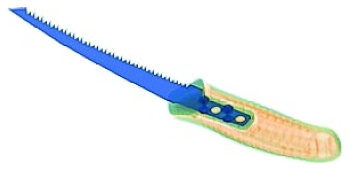

In [7]:
import numpy as np
import cv2
from PIL import Image, ImageDraw, ImageFilter
from google.colab.patches import cv2_imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
from scipy import ndimage, misc

os.mkdir('Cropped')

for filename in images:
  img = cv2.imread(sdir + "/threat_images/" + filename) # Read in the image and convert to grayscale
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  gray = 255*(gray < 245).astype(np.uint8) # To invert the text to white
  coords = cv2.findNonZero(gray) # Find all non-zero points (text)
  x, y, w, h = cv2.boundingRect(coords) # Find minimum spanning bounding box
  rect = img[y:y+h, x:x+w] # Crop the image - note we do this on the original image
  # resized_img = resize(rect, (32, 32))\
  imgn = cv2.cvtColor(rect, cv2.COLOR_BGR2RGB)
  # imgn = 255*(imgn>250).astype(np.uint8)
  plt.axis("off")
  plt.imshow(imgn)
  cv2.waitKey(0)
  cv2.destroyAllWindows()
  plt.imsave("Cropped/"+filename, imgn) # Save the image

In [8]:
imgx = Image.open(sdir + "/background_images/" + images_back[1])
print(imgx.size)

(290, 377)


#### create background image and place threat then after transformation adding those to specified background

In [9]:
import numpy as np
img_back = np.zeros([377,290,3],dtype=np.uint8)
img_back.fill(255) # or img[:] = 255
plt.imsave("backgroundx.jpg",img_back)

In [10]:
# Delete directories in Python using shutil
import shutil
path = 'Outputcheck'
shutil.rmtree(path, ignore_errors=True)

In [11]:
import cv2
import numpy as np
from PIL import Image, ImageDraw, ImageFilter
import skimage.data
from skimage.transform import resize
import matplotlib.pyplot as plt

os.mkdir("Outputcheck")

for i in images:
      # load image
      img1 = Image.open("backgroundx.jpg")
      print(img1.size)

      im = Image.open("Cropped/"+i)
      width , height = im.size
      im_rgb = im.resize((int(width/2),int(height/2)))
      im_rgb = im_rgb.rotate(45,expand = 'True',fillcolor = (255,255,255))
      
      im_rgba = im_rgb.copy()
      im_rgba.putalpha(188)
      im_rgba.save(i[:-4] + ".png")

      img = cv2.imread(i[:-4] + ".png")

      # convert to graky
      gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

      # threshold input image as mask
      mask = cv2.threshold(gray, 250, 255, cv2.THRESH_BINARY)[1]

      # negate mask
      mask = 255 - mask

      # apply morphology to remove isolated extraneous noise
      # use borderconstant of black since foreground touches the edges
      kernel = np.ones((3,3), np.uint8)
      mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
      mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

      # anti-alias the mask -- blur then stretch
      # blur alpha channel
      mask = cv2.GaussianBlur(mask, (0,0), sigmaX=2, sigmaY=2, borderType = cv2.BORDER_DEFAULT)

      # linear stretch so that 127.5 goes to 0, but 255 stays 255
      mask = (2*(mask.astype(np.float32))-255.0).clip(0,255).astype(np.uint8)

      # put mask into alpha channel
      result = img.copy()
      result = cv2.cvtColor(result, cv2.COLOR_BGR2RGBA)
      result[:, :, 3] = mask
      # save resulting masked image

      plt.imsave(i[:-4] + '_threat.png', result, cmap="gray")
      # cv2.imwrite(i[:-4] + '_threat.png', resized_img)
      img2 = Image.open(i[:-4] + '_threat.png')

      img1.paste(img2, (30,200), mask = img2)
      img1.save("Outputcheck/"+ i[:-4]+".png")

# display result, though it won't show transparency
# cv2.imshow("INPUT", img)
# cv2.imshow("GRAY", gray)
# cv2.imshow("MASK", mask)
# cv2.imshow("RESULT", result)
cv2.waitKey(0)
cv2.destroyAllWindows()

(290, 377)
(290, 377)
(290, 377)
(290, 377)
(290, 377)


### Add weights of background and overlay

In [12]:
# Delete directories in Python using shutil
import shutil
path = 'OUTPUT'
shutil.rmtree(path, ignore_errors=True)

In [13]:
import cv2
os.mkdir("OUTPUT")
outcheck = os.listdir("Outputcheck")
background = cv2.imread(sdir + "/background_images/" + images_back[1])
for i in outcheck:
  overlay = cv2.imread("Outputcheck/"+ i)
  added_image = cv2.addWeighted(background,0.4,overlay,0.5,1)
  cv2.imwrite("OUTPUT/" + i, added_image)